In [ ]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Activation
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np

In [ ]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
z_dim = 100

In [ ]:
def generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(28*28*1, activation='tanh'))
    model.add(Reshape(img_shape))
    z = Input(shape=(z_dim,))
    img = model(z)
    return Model(z, img)

In [ ]:
def discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
    img = Input(shape=img_shape)
    prediction = model(img)
    return Model(img, prediction)

In [ ]:
discriminator = discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(), metrics=['accuracy'])
generator = generator(img_shape, z_dim)
z = Input(shape=(100,))
img = generator(z)
discriminator.trainable = False
prediction = discriminator(img)
combined = Model(z, prediction)
combined.compile(loss='binary_crossentropy', optimizer=Adam())

In [ ]:
losses = []
accuracies = []
def train(iterations, batch_size, sample_interval):
    (X_train, _), (_, _) = mnist.load_data()
    data_slice = 2000
    X_train = X_train[:data_slice,:]
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    for iteration in range(iterations):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        g_loss = combined.train_on_batch(z, real)
        if iteration % sample_interval == 0:
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                         (iteration, d_loss[0], 100*d_loss[1], g_loss))
            losses.append((d_loss[0], g_loss))
            accuracies.append(100*d_loss[1])
            sample_images(iteration)

In [ ]:
def sample_images(iteration, image_grid_rows=4, image_grid_columns=4):
    z = np.random.normal(0, 1,
              (image_grid_rows * image_grid_columns, z_dim))
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns,
                                    figsize=(3,3), sharey=True, sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1

In [ ]:
import warnings; warnings.simplefilter('ignore')

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 4ms/step
3000 [D loss: 0.114231, acc.: 96.88%] [G loss: 5.058974]
4/4 [==============================] - 0s 4ms/step
4000 [D loss: 0.135789, acc.: 97.27%] [G loss: 4.959917]
4/4 [==============================] - 0s 4ms/step


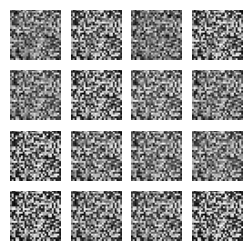

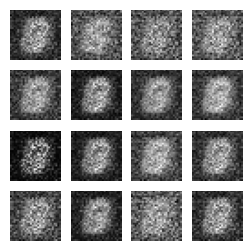

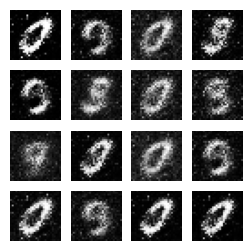

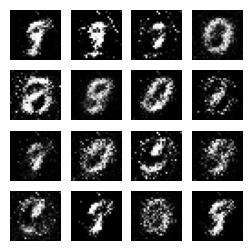

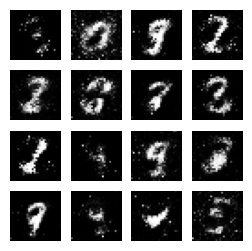

In [ ]:
iterations = 5000
batch_size = 128
sample_interval = 1000
train(iterations, batch_size, sample_interval)